In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
# pobranie danych giełdowych
symbols = ["^WIG20", "^GDAXI", "^GSPC","OTGLF"]  # WIG20, DAX, S&P 500
data = {}

for symbol in symbols:
    df = yf.download(symbol, period="5y", interval="1d")  # 5-letnie dane dzienne
    df["Symbol"] = symbol
    data[symbol] = df
    print(f"Pobrano dane dla {symbol}: {df.shape}")

/tmp/ipython-input-3532351778.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="5y", interval="1d")  # 5-letnie dane dzienne
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^WIG20']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')
/tmp/ipython-input-3532351778.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="5y", interval="1d")  # 5-letnie dane dzienne
[*********************100%***********************]  1 of 1 completed


Pobrano dane dla ^WIG20: (0, 7)
Pobrano dane dla ^GDAXI: (1276, 6)


/tmp/ipython-input-3532351778.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="5y", interval="1d")  # 5-letnie dane dzienne
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3532351778.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="5y", interval="1d")  # 5-letnie dane dzienne
[*********************100%***********************]  1 of 1 completed

Pobrano dane dla ^GSPC: (1256, 6)
Pobrano dane dla OTGLF: (1256, 6)


In [3]:
# Wybór indeksu do analizy
symbol = "^GSPC"  # Można podmienic na symbol pobranego instrumentu
stock_data = data[symbol]
print("Przed czyszczeniem:", stock_data.shape)

Przed czyszczeniem: (1256, 6)


In [4]:
# Wykrywanie ekstremów
n = 10  # Okno do lokalizacji minimów/maksimów
min_indices = argrelextrema(stock_data['Close'].values, np.less, order=n)[0]
max_indices = argrelextrema(stock_data['Close'].values, np.greater, order=n)[0]

In [5]:
# Resetowanie indeksu, aby indeksy liczbowe były zgodne
stock_data = stock_data.reset_index()

In [6]:
# Dodanie kolumn z ekstremami
stock_data['min'] = np.nan
stock_data['max'] = np.nan
stock_data.loc[min_indices, 'min'] = stock_data.loc[min_indices, 'Close']
stock_data.loc[max_indices, 'max'] = stock_data.loc[max_indices, 'Close']

In [7]:
# Przywrócenie indeksu daty
stock_data = stock_data.set_index("Date")
print("Po przetworzeniu ekstremów:", stock_data.shape)

Po przetworzeniu ekstremów: (1256, 8)


In [8]:
# Dodanie wskaźników technicznych
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()
print("Po dodaniu SMA:", stock_data.shape)

Po dodaniu SMA: (1256, 10)


In [9]:
# Usunięcie NaN przez uzupełnianie braków
stock_data.fillna(method='bfill', inplace=True)
print("Po uzupełnieniu brakujących wartości:", stock_data.shape)

Po uzupełnieniu brakujących wartości: (1256, 10)


/tmp/ipython-input-459154463.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='bfill', inplace=True)


In [10]:
# Tworzenie zestawu danych do AI
features = stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_200']]
print("Feature matrix shape:", features.shape)

if features.shape[0] == 0:
    raise ValueError("Brak danych wejściowych! Sprawdź proces przetwarzania danych.")

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print("Po skalowaniu:", features_scaled.shape)

X, y = [], []
lookback = 30  # Liczba dni do analizy
for i in range(lookback, len(features_scaled)):
    X.append(features_scaled[i-lookback:i])
    if not np.isnan(stock_data['max'].iloc[i]):
        y.append(1)  # Spadek
    elif not np.isnan(stock_data['min'].iloc[i]):
        y.append(2)  # Wzrost
    elif stock_data['SMA_50'].iloc[i] > stock_data['SMA_200'].iloc[i]:
        y.append(3)  # Trend wzrostowy
    elif stock_data['SMA_50'].iloc[i] < stock_data['SMA_200'].iloc[i]:
        y.append(4)  # Trend spadkowy
    else:
        y.append(0)  # Brak wzorca

X, y = np.array(X), np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)

Feature matrix shape: (1256, 7)
Po skalowaniu: (1256, 7)
X shape: (1226, 30, 7) y shape: (1226,)


In [11]:
#model = Sequential([
#    LSTM(64, return_sequences=True, input_shape=(lookback, X.shape[2])),
#    Dropout(0.3),
#    LSTM(64, return_sequences=False),
#    Dropout(0.3),
#    Dense(32, activation='relu'),
#    Dense(5, activation='softmax')
#])


In [12]:
model = Sequential([
    LSTM(70, return_sequences=True, input_shape=(lookback, X.shape[2])),  # Zwiększamy jednostki LSTM
    Dropout(0.35),  # Nieco zmniejszamy dropout, lepsze uczenie
    LSTM(64, return_sequences=False),  #jednostki LSTM warstwy 2
    Dropout(0.35),
    Dense(64, activation='relu'),  # Zwiększamy jednostki w Dense
    Dense(32, activation='relu'),  # Więcej jednostek, by model miał więcej reprezentacji
    Dense(16, activation='relu'),
    Dense(5, activation='softmax')  # 5 klas: brak wzorca, spadek, wzrost, trend wzrostowy, trend spadkowy
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5694 - loss: 1.2659 - val_accuracy: 0.7846 - val_loss: 0.9929
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8605 - loss: 0.4396 - val_accuracy: 0.7846 - val_loss: 1.5737
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9215 - loss: 0.2504 - val_accuracy: 0.7846 - val_loss: 1.8980
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9361 - loss: 0.1651 - val_accuracy: 0.7846 - val_loss: 1.9712
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9036 - loss: 0.2688 - val_accuracy: 0.7846 - val_loss: 2.1366
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9666 - loss: 0.1136 - val_accuracy: 0.7846 - val_loss: 2.1225
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9621 - loss: 0.0963 - val_accuracy: 0.7846 - val_loss: 2.1911
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9711 - loss: 0.0859 - val_accuracy: 0.7846 - v

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


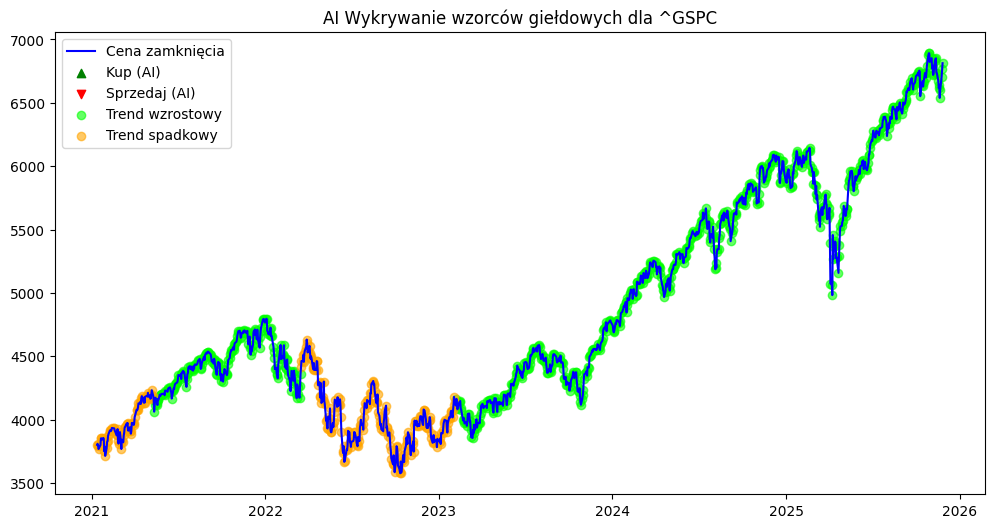

In [13]:
# Predykcja wzorców
predictions = model.predict(X)
pred_labels = np.argmax(predictions, axis=1)

# Wizualizacja wykrytych wzorców
plt.figure(figsize=(12,6))
plt.plot(stock_data['Close'].iloc[lookback:], label='Cena zamknięcia', color='blue')
plt.scatter(stock_data.index[lookback:][pred_labels == 2], stock_data['Close'].iloc[lookback:][pred_labels == 2], label='Kup (AI)', color='green', marker='^', alpha=1)
plt.scatter(stock_data.index[lookback:][pred_labels == 1], stock_data['Close'].iloc[lookback:][pred_labels == 1], label='Sprzedaj (AI)', color='red', marker='v', alpha=1)
plt.scatter(stock_data.index[lookback:][pred_labels == 3], stock_data['Close'].iloc[lookback:][pred_labels == 3], label='Trend wzrostowy', color='lime', marker='o', alpha=0.6)
plt.scatter(stock_data.index[lookback:][pred_labels == 4], stock_data['Close'].iloc[lookback:][pred_labels == 4], label='Trend spadkowy', color='orange', marker='o', alpha=0.6)
plt.title(f"AI Wykrywanie wzorców giełdowych dla {symbol}")
plt.legend()
plt.show()


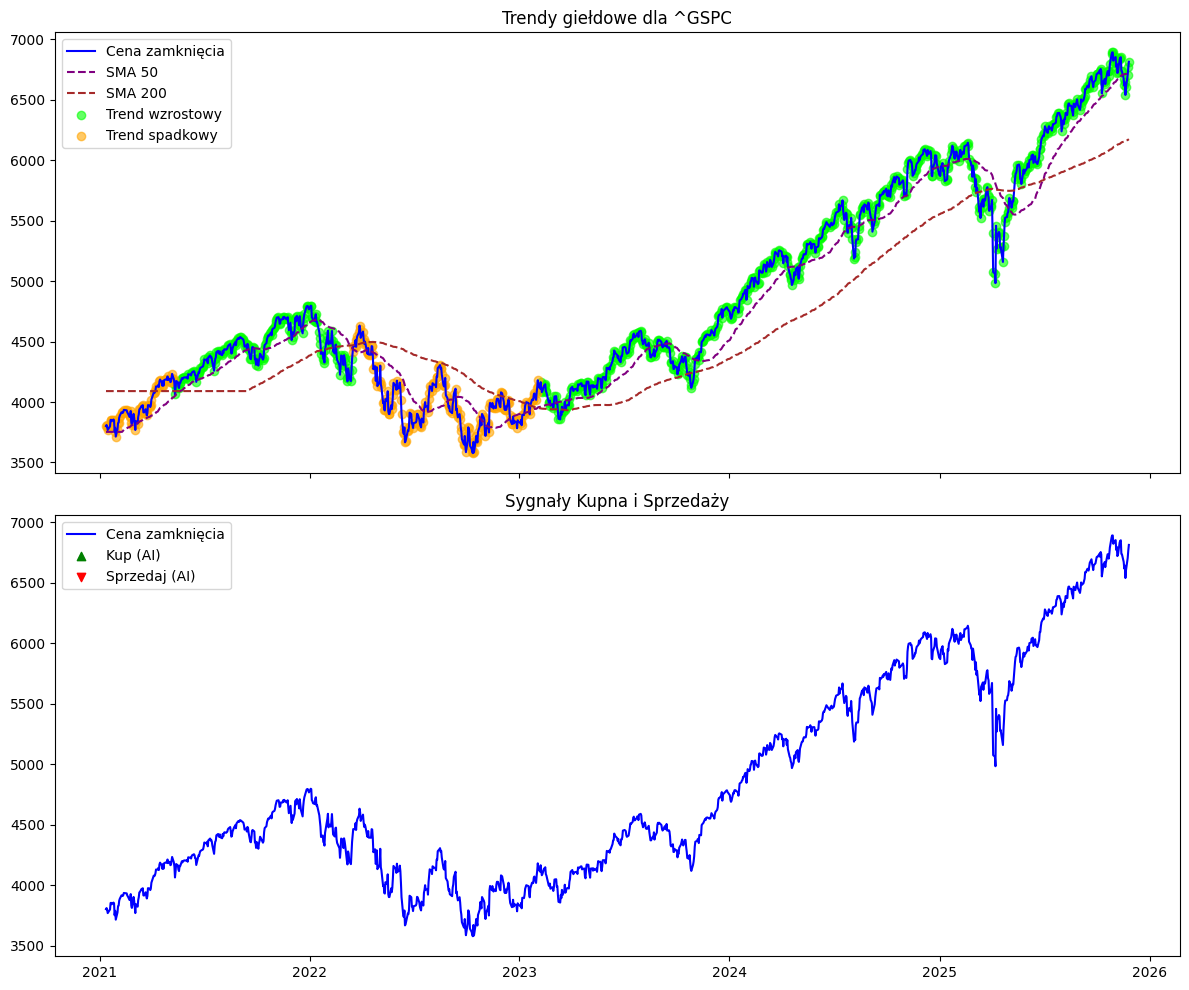

In [14]:
import matplotlib.pyplot as plt

# Tworzenie dwóch osobnych wykresów
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- WYKRES 1: TRENDY ---
axes[0].plot(stock_data.index[lookback:], stock_data['Close'].iloc[lookback:], label='Cena zamknięcia', color='blue')
axes[0].plot(stock_data.index[lookback:], stock_data['SMA_50'].iloc[lookback:], label='SMA 50', color='purple', linestyle='dashed')
axes[0].plot(stock_data.index[lookback:], stock_data['SMA_200'].iloc[lookback:], label='SMA 200', color='brown', linestyle='dashed')

# Oznaczanie trendów
trend_up = pred_labels == 3  # Trend wzrostowy
trend_down = pred_labels == 4  # Trend spadkowy
axes[0].scatter(stock_data.index[lookback:][trend_up], stock_data['Close'].iloc[lookback:][trend_up], label='Trend wzrostowy', color='lime', marker='o', alpha=0.6)
axes[0].scatter(stock_data.index[lookback:][trend_down], stock_data['Close'].iloc[lookback:][trend_down], label='Trend spadkowy', color='orange', marker='o', alpha=0.6)

axes[0].set_title(f'Trendy giełdowe dla {symbol}')
axes[0].legend()

# --- WYKRES 2: SYGNAŁY KUPNA/SPRZEDAŻY ---
axes[1].plot(stock_data.index[lookback:], stock_data['Close'].iloc[lookback:], label='Cena zamknięcia', color='blue')

# Oznaczanie sygnałów kupna i sprzedaży
buy_signals = pred_labels == 2  # Kupno
sell_signals = pred_labels == 1  # Sprzedaż
axes[1].scatter(stock_data.index[lookback:][buy_signals], stock_data['Close'].iloc[lookback:][buy_signals], label='Kup (AI)', color='green', marker='^', alpha=1)
axes[1].scatter(stock_data.index[lookback:][sell_signals], stock_data['Close'].iloc[lookback:][sell_signals], label='Sprzedaj (AI)', color='red', marker='v', alpha=1)

axes[1].set_title('Sygnały Kupna i Sprzedaży')
axes[1].legend()

plt.tight_layout()
plt.show()